In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [2]:
spectrogram_dir = "generes_spectrograms" 
categories = os.listdir(spectrogram_dir)

In [3]:
data = []
labels = []

In [4]:
for category in categories:
    category_path = os.path.join(spectrogram_dir, category)
    for file in os.listdir(category_path):
        file_path = os.path.join(category_path, file)
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (128, 128))
        image = image / 255.0
        data.append(image)
        labels.append(category)

In [5]:
data = np.array(data).reshape(-1, 128, 128, 1)
labels = np.array(labels)

In [6]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_onehot = to_categorical(labels_encoded)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data, labels_onehot, test_size=0.2, random_state=42)

In [8]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax')
])

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model_fit = model.fit(X_train, y_train,validation_data=(X_test,y_test),epochs=50, batch_size=32)

Epoch 1/50
25/25 [==============================] - 63s 1s/step - loss: 2.8220 - accuracy: 0.1139 - val_loss: 2.2995 - val_accuracy: 0.1150
Epoch 2/50
25/25 [==============================] - 24s 936ms/step - loss: 2.2972 - accuracy: 0.1189 - val_loss: 2.2850 - val_accuracy: 0.0600
Epoch 3/50
25/25 [==============================] - 22s 891ms/step - loss: 2.2152 - accuracy: 0.1402 - val_loss: 2.2166 - val_accuracy: 0.1250
Epoch 4/50
25/25 [==============================] - 22s 895ms/step - loss: 2.1733 - accuracy: 0.1915 - val_loss: 2.1714 - val_accuracy: 0.1650
Epoch 5/50
25/25 [==============================] - 21s 855ms/step - loss: 2.1348 - accuracy: 0.1990 - val_loss: 2.1773 - val_accuracy: 0.1550
Epoch 6/50
25/25 [==============================] - 21s 858ms/step - loss: 2.0918 - accuracy: 0.2453 - val_loss: 2.0681 - val_accuracy: 0.2150
Epoch 7/50
25/25 [==============================] - 22s 897ms/step - loss: 2.0421 - accuracy: 0.2478 - val_loss: 2.0601 - val_accuracy: 0.2600
Ep

In [11]:
model.save("cnn_raw_model.h5")

In [12]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=64)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

4/4 [==============================] - 0s 85ms/step - loss: 1.7861 - accuracy: 0.5650
Test Loss: 1.7861
Test Accuracy: 0.5650


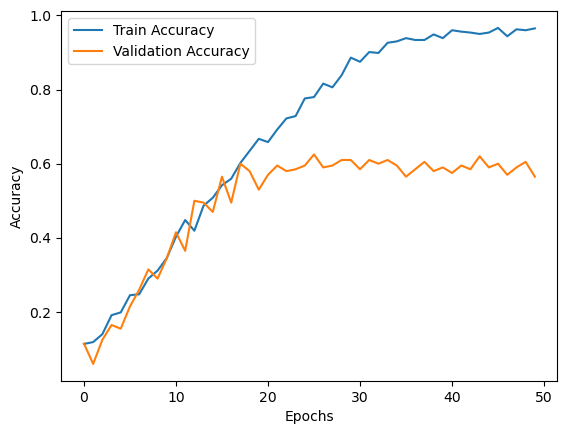

In [13]:
plt.plot(model_fit.history['accuracy'], label='Train Accuracy')
plt.plot(model_fit.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

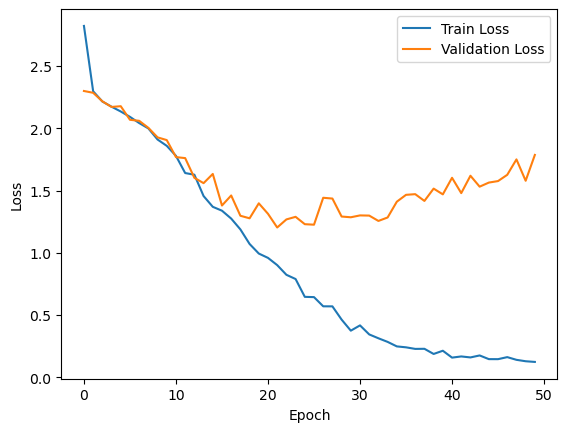

In [14]:
plt.plot(model_fit.history['loss'], label='Train Loss')
plt.plot(model_fit.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [2]:
import librosa
import numpy as np
import cv2
from tensorflow.keras.models import load_model

In [15]:
cnn_model = load_model("cnn_raw_model.h5") 

In [16]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 30, 30, 64)       

In [18]:
metrics = cnn_model.evaluate(X_test, y_test)
print("Metrics:", metrics)

7/7 [==============================] - 1s 64ms/step - loss: 1.7613 - accuracy: 0.5900
Metrics: [1.761253833770752, 0.5899999737739563]


In [56]:
import librosa
import numpy as np
import cv2
from tensorflow.keras.models import load_model

cnn_model = load_model("cnn_raw_model.h5")
categories = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]

def into_spectrogram(file_path, img_size=(128, 128)):
    try:
        y, sr = librosa.load(file_path, sr=22050, duration=30)

        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max) 
        
        mel_spec_normalized = mel_spec_db - np.min(mel_spec_db)
        mel_spec_normalized /= np.max(mel_spec_normalized)

        mel_spec_resized = cv2.resize(mel_spec_normalized, img_size)

        mel_spec_input = np.expand_dims(mel_spec_resized, axis=(0, -1))
        return mel_spec_input
    except Exception as e:
        print(f"Error processing audio: {e}")
        return None

def predict_audio_category(file_path):
    spectrogram = preprocess_audio(file_path)
    if spectrogram is not None:
        prediction = cnn_model.predict(spectrogram)
        predicted_label = np.argmax(prediction, axis=1)
        return categories[predicted_label[0]]
    else:
        return "Error processing audio file"

file_path = "C:\\Users\\srira\\OneDrive\\Desktop\\Fall 24\\Feature Engineering\\Project\\generes_raw\\disco\\disco.00058.wav"  # Replace with your audio file path
predicted_category = predict_audio_category(file_path)
print(f"Predicted Category: {predicted_category}")


1/1 [==============================] - 0s 57ms/step
Predicted Category: disco
